# The importance of choosing the right metric, in other words, don't trust everything labeled as 'Machine learning'

## Original article
An article *Health challenges and acute sports injuries restrict weightlifting training of older athletes* published in *BMJ Open Sport & Exercise Medicine* in 2022 shows an interesting study of factors influencing injuries of master athletes who are dedicating their time to weightlifting.
* Huebner M, Ma W Health challenges and acute sports injuries restrict weightlifting training of older athletes BMJ Open Sport & Exercise Medicine 2022;8:e001372. doi: 10.1136/bmjsem-2022-001372

Dataset based on an online survey amongst top weightlifters from various continents and various ages is made publicly available and is thus open to further investigations ([https://doi.org/10.5061/dryad.51c59zwb3](https://doi.org/10.5061/dryad.51c59zwb3)).

We are not going to delve deep into the original article, specific questions and considered injury predictors are not of importance for this notebook, we'll just provide a brief overview of its implementation of *machine learning models*. Several machine learning algorithms were used to "evaluate potentially complex interactions of age, sex, health-related and training-related predictors of injuries". Since the goal here is to predict injury, the task at hand is a classification problem. For this purpose the authors implemented:
* support vector machines,
* generalised boosted methods,
* regularised logistic regression,
* random forests, and
* one layer neural network.

These classifiers were trained using 10-fold repeated cross-validation to tune hyperparameters on 80 % of the data as a training set. Remaining 20 % were used for model evaluation using *accuracy* as a metric.

## Their results

All the classifiers the authors implemented yielded comaparable accuracy as shown in **Table 2** of the original article.

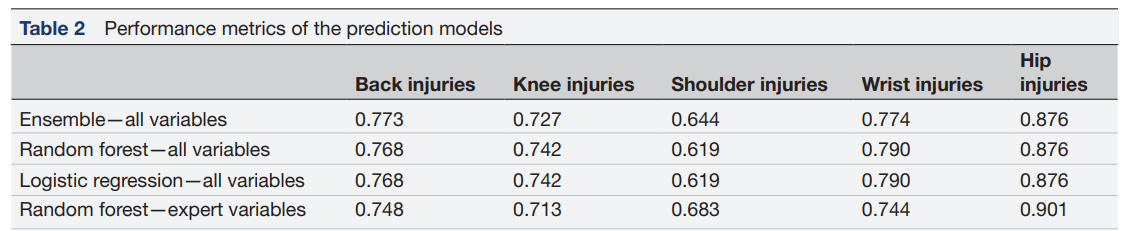

In [1]:
%matplotlib inline
from IPython.display import Image

# Read the image
Image('/kaggle/input/weightlifting-injuries-in-master-athletes/'
      'Table 2 orig article.png')

So they are able to predict injuries in master wightlifters with accuracy of about 75 % and for hip injuries with about 90 % accuracy! So the authors calculated feature importance metrics and made conclusions about variables that have the strongest influence on occurence of injury.

**This sounds fairly impressive, doesn't it?** Well, yes, except for one very significant detail. And this one is a biggie. But let's inspect the data ourselves.

# Exploratory data analysis

## Importing libraries

We import standard data handling libraries (**Pandas**, **NumPy**), visualisation libraries (**PyPlot**, **Seaborn**) as well as some machine learning libraries (**SciKit-learn** and **PyTorch**). All the imports are handled at top of the file in accordance with PEP 8 standard. (Since this notebook is not meant as a learning tool for others we do not comply here with the more illustrative approach of importing things 'on the go' in respective cells.)

In [2]:
# skorch allow for easy integration of PyTorch neural nets into SciKit-learn
# modules – pipelines, Grid/RandomisedSearchCV etc.
!pip install skorch
import pandas as pd  # data import and handling
import numpy as np
import seaborn as sns  # specific statistical plots, visual adjustments
import sklearn.pipeline as pp
import statsmodels.api as sm
import torch
import torch.optim as optim
import torch.nn as nn
import warnings
from IPython.display import Image
from matplotlib import pyplot as plt  # plotting the data
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
    f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, \
    StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
warnings.filterwarnings('ignore', category=FutureWarning)

# sets graphical style for plots
sns.set_theme(style='ticks', palette='bright')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 6.2 MB/s eta 0:00:00


## Data import, data quality checks

**Point of this notebook is nowhere to be found in this part, feel free to skip to the next one.**

Let us load in the data and have a first look at specific columns/features.

In [3]:
# data import
data = pd.read_csv('/kaggle/input/weightlifting-injuries-in-master-athletes/'
                   'wlinj_dryad.csv',
                   index_col=0)
# display head for first look
data.head()

,sex,age,agegrp3,age_start,yrs_experience,shoulder,knees,back,wrist,hips,...,sport0_cf,sport0_ball,sport0_fit,sport0_endure,sport0_track,sport0_ma,sport0_yoga,sport0_gym,sport0_strength,sport0_impact
id,,,,,,,,,,,,,,,,,,,,,
1,m,42,35-44,41,1,0,1,0,0,no,...,0,1,0,0,0,0,0,0,0,1
2,m,54,45-59,16,38,1,0,0,0,no,...,0,0,0,0,0,0,0,0,0,0
3,m,40,35-44,36,4,0,0,1,1,no,...,1,1,1,1,1,1,0,0,1,1
4,m,37,35-44,32,5,0,1,0,0,no,...,1,1,0,0,0,1,0,0,0,1
5,f,48,45-59,45,3,0,0,0,0,no,...,1,0,0,1,0,0,1,0,0,1


In [4]:
# let's gather some info about the data
info = pd.DataFrame(index=data.columns)
# types of individual features
info['types'] = data.dtypes
# check for missing values
info['num_NA'] = data.isna().sum().to_frame()
# number of unique values per feature
info['num_uniques'] = data.nunique()
info

,types,num_NA,num_uniques
sex,object,0,2
age,int64,0,51
agegrp3,object,0,3
age_start,int64,0,69
yrs_experience,int64,0,67
shoulder,int64,0,2
knees,int64,0,2
back,int64,0,2
wrist,int64,0,2
hips,object,0,2


We have no missing data (this is not surprising – the dataset was pre-processed for the original study). This leaves out part of data preparation concerns.

Some categorical data (sex, agegrp3 and ) is still coded as strings instead of numbers. As those are either binomial (sex and hips) or ordinal (agegrp3), let's use simple label encoding.

In [5]:
# recoding string coded variables
data.hips = data.hips.replace({'yes': 1, 'no': 0}).astype(int)
data.sex = data.sex.replace({'m': 0, 'f': 1}).astype(int)
data.agegrp3 = data.agegrp3.replace({'35-44': 1, '45-59': 2, '60+': 3}
                                    ).astype(int)

## Injuries columns

Majority of the columns here are not important for this notebook as they describe predictor features and the notebook aims to point out issues with the original analysis, not to identify injury predictors.

Columns of importance here are *shoulder*, *knees*, *back*, *wrist* and *hips* as these are 0-1 categorical variables indicating whether the subject was injured in the described location. These serve as **targets** for implemented classifiers.

Let's add a column describing injury occuring in any location at all, even though this has not been done in the original study.

In [6]:
# add agregated injury column
data['injury'] = ((data['shoulder'] == 1) ^ (data['knees'] == 1) ^
                  (data['back'] == 1) ^ (data['wrist'] == 1) ^
                  (data['hips'] == 1)).astype(int)

Let's create list of these injury locations for convenience and look at some statistics.

In [7]:
inj_loc = ['back', 'knees', 'shoulder', 'wrist', 'hips', 'injury']
# descriptives of the data – returns: N, mean, std, min, 25%, 50%, 75%, max
data[inj_loc].describe()

,back,knees,shoulder,wrist,hips,injury
count,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000
mean,0.234631,0.264344,0.351434,0.216189,0.126025,0.415984
std,0.423985,0.441210,0.477663,0.411855,0.332047,0.493143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Compare the means (corresponding to frequency of injury occurence) to the accuracies reported by classifiers from the original article:

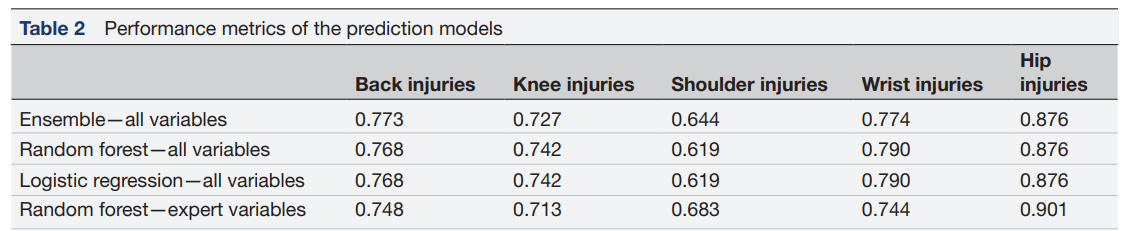

In [8]:
Image('/kaggle/input/weightlifting-injuries-in-master-athletes/'
      'Table 2 orig article.png')

Can you see the issue here?

## So what's the issue with the original article?

Let's visualize the accuracies reported by the original article together with the distribution of the data.

Reminder: *Injury* was not part of the original study, hence no accuracies are reported.

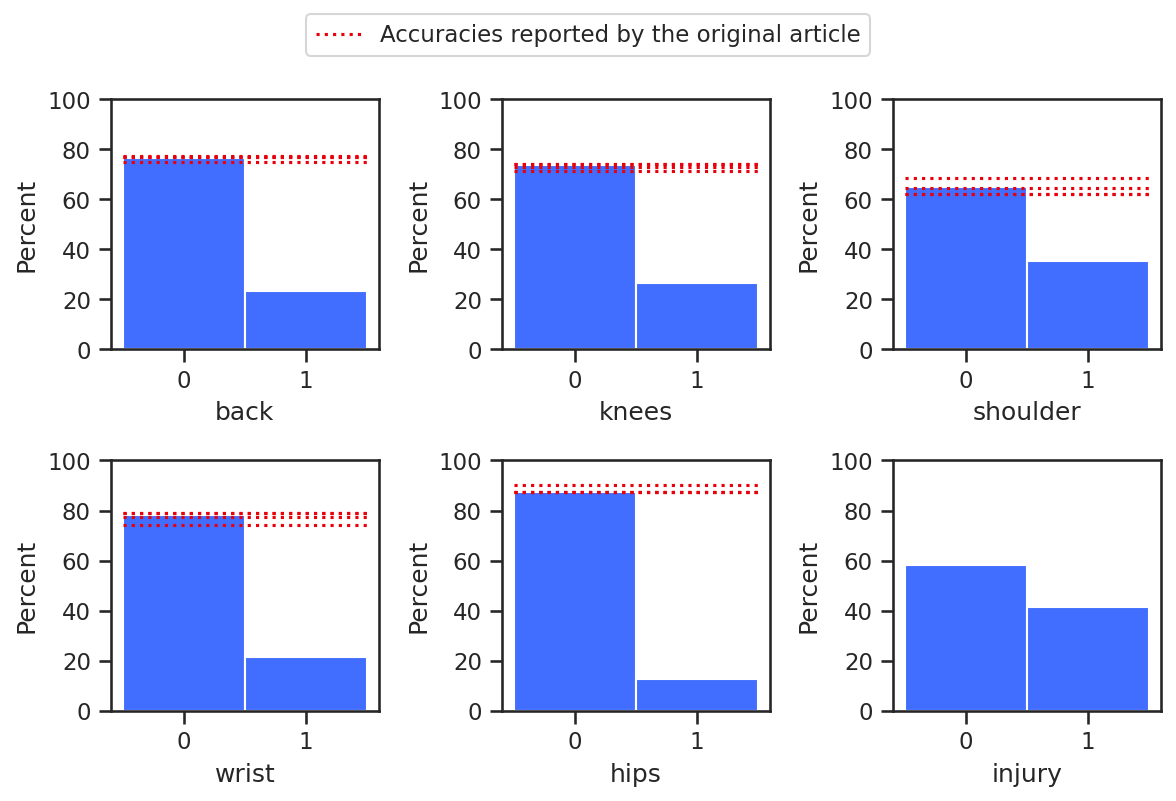

In [9]:
# setting up the accuracies from the original study
orig_accur = {'back': [.773, .768, .768, .748],
              'knees': [.727, .742, .742, .713],
              'shoulder': [.644, .619, .619, .683],
              'wrist': [.774, .790, .790, .744],
              'hips': [.876, .876, .876, .901],
              'injury': []}
# setting up plot
fig, axs = plt.subplots(2, 3, figsize=(8, 5), dpi=150)
ax = axs.ravel()
for i, loc in enumerate(data[inj_loc]):
    # ploting frequency of the data
    sns.histplot(data, x=loc, stat='percent',  # data to display
                 discrete=True,  # adjusts bin-width
                 ax=ax[i])  # placement within subplots
    # plotting reported accuracies
    ax[i].hlines([k*100 for k in orig_accur[loc]],
                 -0.5, 1.5,
                 'r', linestyle=':', label='accuracy')
    ax[i].set_ylim(0, 100)

# visual adjustments
fig.legend(['Accuracies reported by the original article'],
           loc='upper center', bbox_to_anchor=(0.5, 1.08))
fig.tight_layout()
plt.show()

# cleaning up
plt.close(fig)
del loc, fig, ax, axs

**Accuracies reported by the original article correspond to the percentage of the majority category in the data. Why is this a problem?**

Imagine that you predict every single person as being negative regarding being prone ot injury. Accuracy of such predictions would be exactly the percentage of the negative category in the data (labeled 0 here) as the accuracy measures only correctly classified cases. It doesn't take into account mislabeled cases at all.

So even though you have performed some algorithms, which can be analysed for feature importance measuring how influential are individual features for the model predictions, the **model doesn't really predict anything**. Reporting such features and claiming they have some predictive power for the injury prediction is definitely far fetched.

Let's simulate the procedure of the original study and show that such classifiers do not have any reasonable predictive power whatsoever.

# Machine learning classifiers

Here we will replicate the procedure used in the original study, "training" various classifiying algorithms on the supplemented data with accuracies similar to the ones from the original study, while *looking at metrics that are actually relevant to this problem*. 

First we define structure of the further used neural network. This neural network is more complex than the one used in the study (yet we will see it yields similarly bad results).

In [10]:
class MyModel(nn.Module):
    """Feed-forward Neural Network used here."""

    def __init__(self, hid_feat, out_feat):
        super().__init__()
        # PyTorch 'nn.LazyLinear' layers can adapt the number of inputs to the
        # provided input tensor not knowing it's exact size (e.g. due to feature
        # selection in pipeline with grid/random search for good number of input
        # features).
        # They are currently under heavy development, so:
        warnings.filterwarnings('ignore', category=UserWarning, module='torch')
        self.layer1 = nn.LazyLinear(hid_feat)
        # normal linear hidden layer
        self.layer2 = nn.Linear(hid_feat, out_feat)
        self.drop = nn.Dropout(0.4)

    def forward(self, my_input):
        """
        Forward propagation of data in the NN.

        Args_
        input: The propagated data.

        Returns_
        Resulting output produced by the NN.
        """
        layer1a = torch.sigmoid(self.layer1(my_input))
        layer1a = self.drop(layer1a)
        layer2a = torch.sigmoid(self.layer2(layer1a))
        return layer2a

## Simulating results of the original article.

Let's fit models they have used in the original article with similar procedure parameters:
* using 80-20 train-test split (stratified),
* using 10 fold (stratified) cross-validation,
* searching for optimal hyper-parameters with Grid Search with accuracy as a target.

Since the original article is a bit foggy about the algortihms they've actually used (eg., referring to one only by 'ensemble methods'), we have decided to include following classifiers:
* Dummy Classifier – doesn't actually classify, it is set up to classify everything as negative, to show that the other classfifiers do not behave well,
* GradientBoostingClassifier,
* RandomForestClassifier,
* LogisticRegression, and
* Forward-feed Neural Network.

Even though we are storing every trained model identified by GridSearchCV into a dictionary so they can be recalled later, we find it easier to simultaniously store their perfomance metrics into a Pandas dataframe. A plot of ROC and precision-recall curves of these classifiers is also created to inspect their parameters as classifiers later on.

In [11]:
# setting different plot theme
sns.set_theme(style='whitegrid', palette='bright')
# setting a random state to replicate randomised results
rnd = np.random.RandomState(10)

# creating resulting scores table to store all scores
cls_nm = ['dummy', 'GBC', 'RFC', 'Log', 'FNN']  # abbrev of classifiers
scores = ['accuracy', 'recall', 'precision', 'f1', 'AUC']
index = pd.MultiIndex.from_product([inj_loc, scores],
                                   names=['Injury location', 'Score'])
scores = pd.DataFrame(index=index,
                      dtype=float)
del index  # cleaning up

# set up for plots
# =============================================================================
fig = plt.figure(figsize=(10, 30), dpi=150)
subfigs = fig.subfigures(6, 1)
colors = ['r', 'g', 'b', 'orange', 'm']  # to ensure color consistency in plots
# set up to plot f1 score contours
array_0_1 = np.linspace(0.01, 1, 100)
f1_grid = np.empty((100, 100))
for i, a in enumerate(array_0_1):
    for ii, b in enumerate(array_0_1):
        f1_grid[i, ii] = 2*a*b/(a+b)
grid = np.meshgrid(array_0_1, array_0_1)
del array_0_1, i, a, ii, b

# actual models
# =============================================================================
# storage for all the best models
trained_best = {}

# folds for Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rnd)

# define pipeline for GridSearch over different estimators
pipeline = pp.Pipeline([('scaler', MinMaxScaler()),
                        ('estim', LogisticRegression())])

# specify the neural network  as a sklearn estimator using Skorch library
# -----------------------------------------------------------------------
stopper = EarlyStopping()
net = NeuralNetBinaryClassifier(module=MyModel(hid_feat=1, out_feat=1),
                                optimizer=optim.Adam,
                                max_epochs=30,
                                device='cuda',
                                callbacks=[stopper],
                                verbose=0)
# parameter/estimator grid to search over
params = [
          # Dummy Classifier – assigns everything with 0
          {'estim': [DummyClassifier(strategy='most_frequent')]},
          # GBC
          {'estim': [GradientBoostingClassifier(max_features='sqrt',
                                                random_state=rnd)],
           'estim__learning_rate': [0.01, 0.1, 0.2, 0.5],
           'estim__n_estimators': [10, 20, 50],
           'estim__max_depth': [1, 2]
           },
          # Random Forest
          {'estim': [RandomForestClassifier(max_features='sqrt',
                                            random_state=rnd)],
           'estim__n_estimators': [30, 50, 100],
           'estim__max_depth': [2, 3]
           },
          # Logistic regression
          {'estim': [LogisticRegression(max_iter=1000,
                                        random_state=rnd)],
           'estim__C': [0.01, 0.1, 1, 10, 100]
           },
          # FNN
          {'estim': [net],
           'estim__module__hid_feat': range(500, 3001, 500),
           'estim__module__out_feat': [1]
           }
          ]

# set up work dataframe and selecting relevant data
df = data.copy().astype(np.float32)
X = df.copy()
X = X.drop(inj_loc, axis='columns')

# loops through different locations of injuries
# =============================================================================
for i, loc in enumerate(inj_loc):
    print('\n\n\n',
          '================================================================\n',
          loc, '\n',
          '================================================================'
          '\n')
    # select response variable
    y = df[loc]

    # split into train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                        stratify=y,
                                                        random_state=rnd)

    # create key to store best estimated models
    trained_best[loc] = []
    # initialise plot for given injury location
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(loc)

    # loops through different estimators in parameter/estimator grid
    # =========================================================================
    # NOTE: if I was looking for the best classifier, I would ommit this
    # loop and pass the whole params as a param_grid into GridSearchCV
    for ii, param_grid in enumerate(params):
        # set up grid-search cross validation, score for accuracy
        model = GridSearchCV(pipeline,
                             param_grid,
                             cv=skf,
                             scoring='accuracy',
                             n_jobs=-1,
                             refit=True,
                             verbose=1)

        # fit the model
        model.fit(X_train, y_train)

        # select, display and store the best model
        best_model = model.best_estimator_  # select
        print(best_model.named_steps['estim'], '\n')  # display
        trained_best[loc].append(best_model)  # store

        # model prediction for TEST sets
        # =================================================================
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # model  scoring for TEST set
        # =====================================================================
        # accuracy
        acc = accuracy_score(y_test, y_pred)
        scores.loc[(loc, 'accuracy'), cls_nm[ii]] = acc
        # recall
        recall = recall_score(y_test, y_pred)
        scores.loc[(loc, 'recall'), cls_nm[ii]] = recall
        # precision
        precision = precision_score(y_test, y_pred)
        scores.loc[(loc, 'precision'), cls_nm[ii]] = precision
        # f1 score
        f1 = f1_score(y_test, y_pred)
        scores.loc[(loc, 'f1'), cls_nm[ii]] = f1
        # compute AUC
        auc = roc_auc_score(y_test, y_prob)
        scores.loc[(loc, 'AUC'), cls_nm[ii]] = auc

        # plotting ROC curves
        # =====================================================================
        # calculating FPR and TPR for each threshold level
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        # plot ROC curve
        axs[0].plot(fpr, tpr,
                    label=f'{cls_nm[ii]}',
                    color=colors[ii])
        # find index of the threshold closest to 0.5
        thr_idx = np.argmin(np.abs(thresh - 0.5))
        # plot the defauls decision point onto ROC curve
        axs[0].plot(fpr[thr_idx], tpr[thr_idx],
                    color=colors[ii], marker='o',
                    zorder=10)
        # subplots visual adjustments
        axs[0].set_title('ROC curve')
        axs[0].set_xlabel('FPR')
        axs[0].set_ylabel('TPR')
        axs[0].legend(loc='lower right')

        # plotting precision-recall curves
        # =====================================================================
        # plotting f1 contours
        f1_score_plot = axs[1].contour(grid[0], grid[1], f1_grid,
                                       levels=np.arange(0, 1, 0.1),
                                       linestyles='dotted', colors='k')
        axs[1].clabel(f1_score_plot, inline=True, fontsize=8)

        # calculating precision and recall for each threshold level
        prec, rec, thresh = precision_recall_curve(y_test, y_prob)
        # plot ROC curve
        axs[1].plot(rec, prec,
                    label=f'{cls_nm[ii]}',
                    color=colors[ii])
        # find index of the threshold closest to 0.5
        thr_idx = np.argmin(np.abs(thresh - 0.5))
        # plot the defauls decision point onto ROC curve
        axs[1].plot(rec[thr_idx], prec[thr_idx],
                    color=colors[ii], marker='o',
                    zorder=10)
        # subplots visual adjustments
        axs[1].set_title('precision-recall')
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].legend(loc='upper right')

    for ax in axs.flat:
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)

# save plot
plt.savefig('ROC unequal train.png', bbox_inches='tight')
plt.close(fig)

# cleaining up
del acc, auc, ax, axs, best_model, loc, params, skf

# extract accuracies from scores
accuracies = scores.drop(['recall', 'precision', 'f1', 'AUC'],
                         axis='index', level='Score').copy()
accuracies = accuracies.droplevel('Score', axis='index')




 back 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
DummyClassifier(strategy='most_frequent') 

Fitting 10 folds for each of 24 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(max_depth=2, max_features='sqrt', n_estimators=20,
                           random_state=RandomState(MT19937) at 0x7C5E0722EA40) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier(max_depth=2, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5E0722EB40) 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.01, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5E0722EC40) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
) 




 knees 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DummyClassifier(strategy='most_frequent') 

Fitting 10 folds for each of 24 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_features='sqrt',
                           n_estimators=20,
                           random_state=RandomState(MT19937) at 0x7C5DB2E1F540) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=2, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5DB2E1F640) 

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(C=0.01, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DB2E1F840) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
) 




 shoulder 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DummyClassifier(strategy='most_frequent') 

Fitting 10 folds for each of 24 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.2, max_depth=1, max_features='sqrt',
                           n_estimators=50,
                           random_state=RandomState(MT19937) at 0x7C5DB2E1F740) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=3,
                       random_state=RandomState(MT19937) at 0x7C5DB2E1FB40) 

Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.1, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DB2E1FA40) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
) 




 wrist 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
DummyClassifier(strategy='most_frequent'

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 10 folds for each of 24 candidates, totalling 240 fits
GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='sqrt',
                           n_estimators=10,
                           random_state=RandomState(MT19937) at 0x7C5DB2E1F940) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier(max_depth=2, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5DB2E1FC40) 

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(C=0.01, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DB2E1FD40) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
) 




 hips 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DummyClassifier(strategy='most_frequent') 

Fitting 10 folds for each of 24 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='sqrt',
                           n_estimators=10,
                           random_state=RandomState(MT19937) at 0x7C5DB2E1FE40) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier(max_depth=2, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5DA02B4040) 

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(C=0.01, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DA02B4240) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
) 




 injury 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DummyClassifier(strategy='most_frequent') 

Fitting 10 folds for each of 24 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.5, max_depth=1, max_features='sqrt',
                           n_estimators=50,
                           random_state=RandomState(MT19937) at 0x7C5DA02B4840) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=3, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5DA02B4A40) 

Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.01, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DA02B4C40) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=1000, bias=True)
    (layer2): Linear(in_features=1000, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
) 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Even the fact that attempts to calculate precision result in an error suggest that these classifiers do not really classify at all, and simply assign everything with a negative label. But let us compare accuracies of our classifiers with the accuracies from the original study.

Let's create heatmaps for both, so we can do quick visual check on how we are doing.

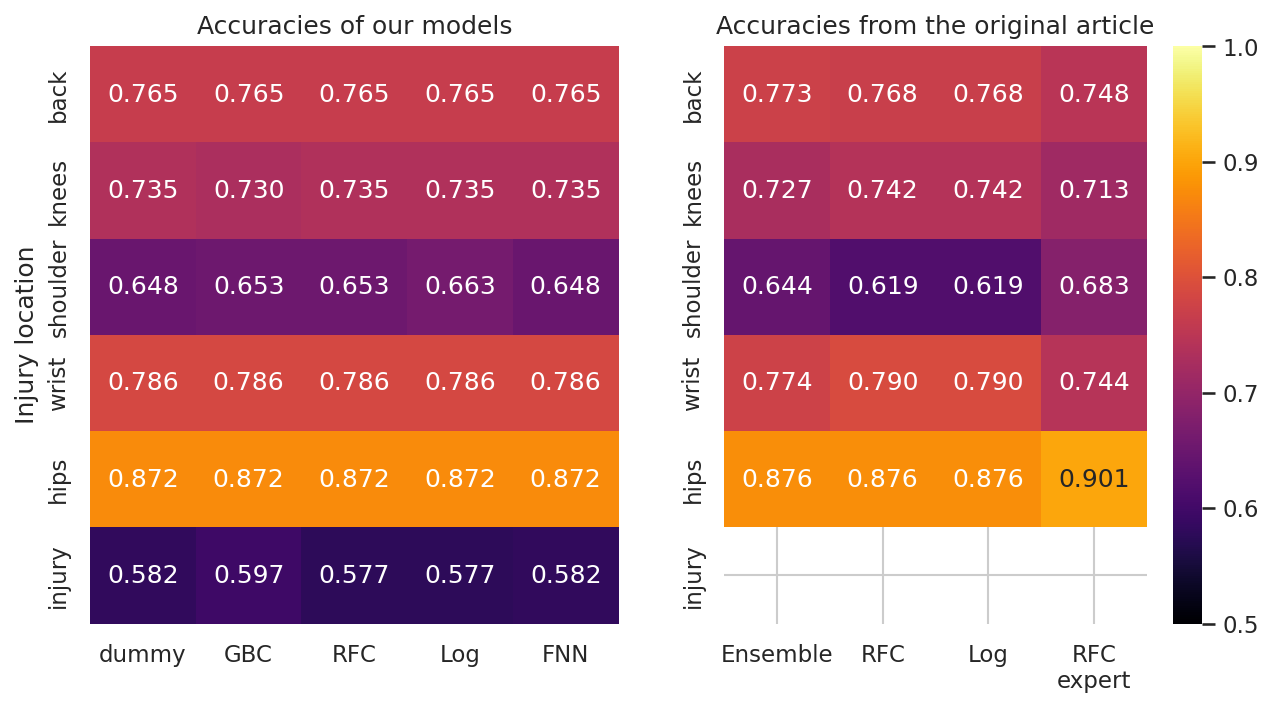

In [12]:
# accuracies from original article
orig_accur['injury'] = ['nan' for k in range(4)]
orig_acc = pd.DataFrame(orig_accur,
                        index=['Ensemble', 'RFC', 'Log',
                               'RFC\nexpert'])
orig_acc.replace('nan', np.nan, inplace=True)
orig_acc = orig_acc.transpose()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
# accuracy heatmaps
axs[0].set_title('Accuracies of our models')
sns.heatmap(accuracies,
            cmap='inferno', cbar=False, vmin=0.5, vmax=1.0,
            square=False, annot=True, fmt='.3f',
            ax=axs[0])
axs[1].set_title('Accuracies from the original article')
sns.heatmap(orig_acc,
            cmap='inferno', cbar=True, vmin=0.5, vmax=1.0,
            square=False, annot=True, fmt='.3f',
            ax=axs[1])
plt.show()
plt.close()

**So the accuracies of our classifiers are very comparable to the classifiers of the original study.**

To be fair here – it looks like are classifiers are really defaulting to assigning everything with the negative label, while their classifiers attempted to classify at least some cases. Yet the accuracy they've obtained doesn't actually provide any information about their performance – compare it to the *dummy classifier* that actually classifies every case with negative label. Any minor increase over this can be attributed purely to the luck with train-test split selection and cannot be called to be reasonably generalizable.

Let's point out that the original study includes features (specifically information about selected chronical illnesses of the respondents), that are not provided in the published dataset. Should these informations be provided, it is possible that the algorithms trained here would perform a better job at injury classification.

Let's look at the various metrics for our classifiers that are actually relevant to this case.

In [13]:
scores.round(3)

dummy    GBC    RFC    Log    FNN
Injury location Score                                       
back            accuracy   0.765  0.765  0.765  0.765  0.765
                recall     0.000  0.000  0.000  0.000  0.000
                precision  0.000  0.000  0.000  0.000  0.000
                f1         0.000  0.000  0.000  0.000  0.000
                AUC        0.500  0.536  0.509  0.597  0.500
knees           accuracy   0.735  0.730  0.735  0.735  0.735
                recall     0.000  0.019  0.000  0.000  0.000
                precision  0.000  0.333  0.000  0.000  0.000
                f1         0.000  0.036  0.000  0.000  0.000
                AUC        0.500  0.625  0.641  0.642  0.500
shoulder        accuracy   0.648  0.653  0.653  0.663  0.648
                recall     0.000  0.087  0.014  0.145  0.000
                precision  0.000  0.545  1.000  0.588  0.000
                f1         0.000  0.150  0.029  0.233  0.000
                AUC        0.500  0.580  0.577  0.575  0.500
wrist           accuracy   0.786  0.786  0.786  0.786  0.786
                recall     0.000  0.000  0.000  0.000  0.000
                precision  0.000  0.000  0.000  0.000  0.000
                f1         0.000  0.000  0.000  0.000  0.000
                AUC        0.500  0.617  0.647  0.587  0.500
hips            accuracy   0.872  0.872  0.872  0.872  0.872
                recall     0.000  0.000  0.000  0.000  0.000
                precision  0.000  0.000  0.000  0.000  0.000
                f1         0.000  0.000  0.000  0.000  0.000
                AUC        0.500  0.454  0.498  0.486  0.500
injury          accuracy   0.582  0.597  0.577  0.577  0.582
                recall     0.000  0.341  0.012  0.000  0.000
                precision  0.000  0.528  0.333  0.000  0.000
                f1         0.000  0.415  0.024  0.000  0.000
                AUC        0.500  0.591  0.522  0.562  0.500

Simple look at precison and recall obtained from these classifiers shows that the vast majority of them just labels everything with a negative label. What is these classifiers are trained reasonably, only the default decision threshold of 0.5 does not work well for their predictions? Let's inspect the ROC and precision-recall curves we have created earlier.

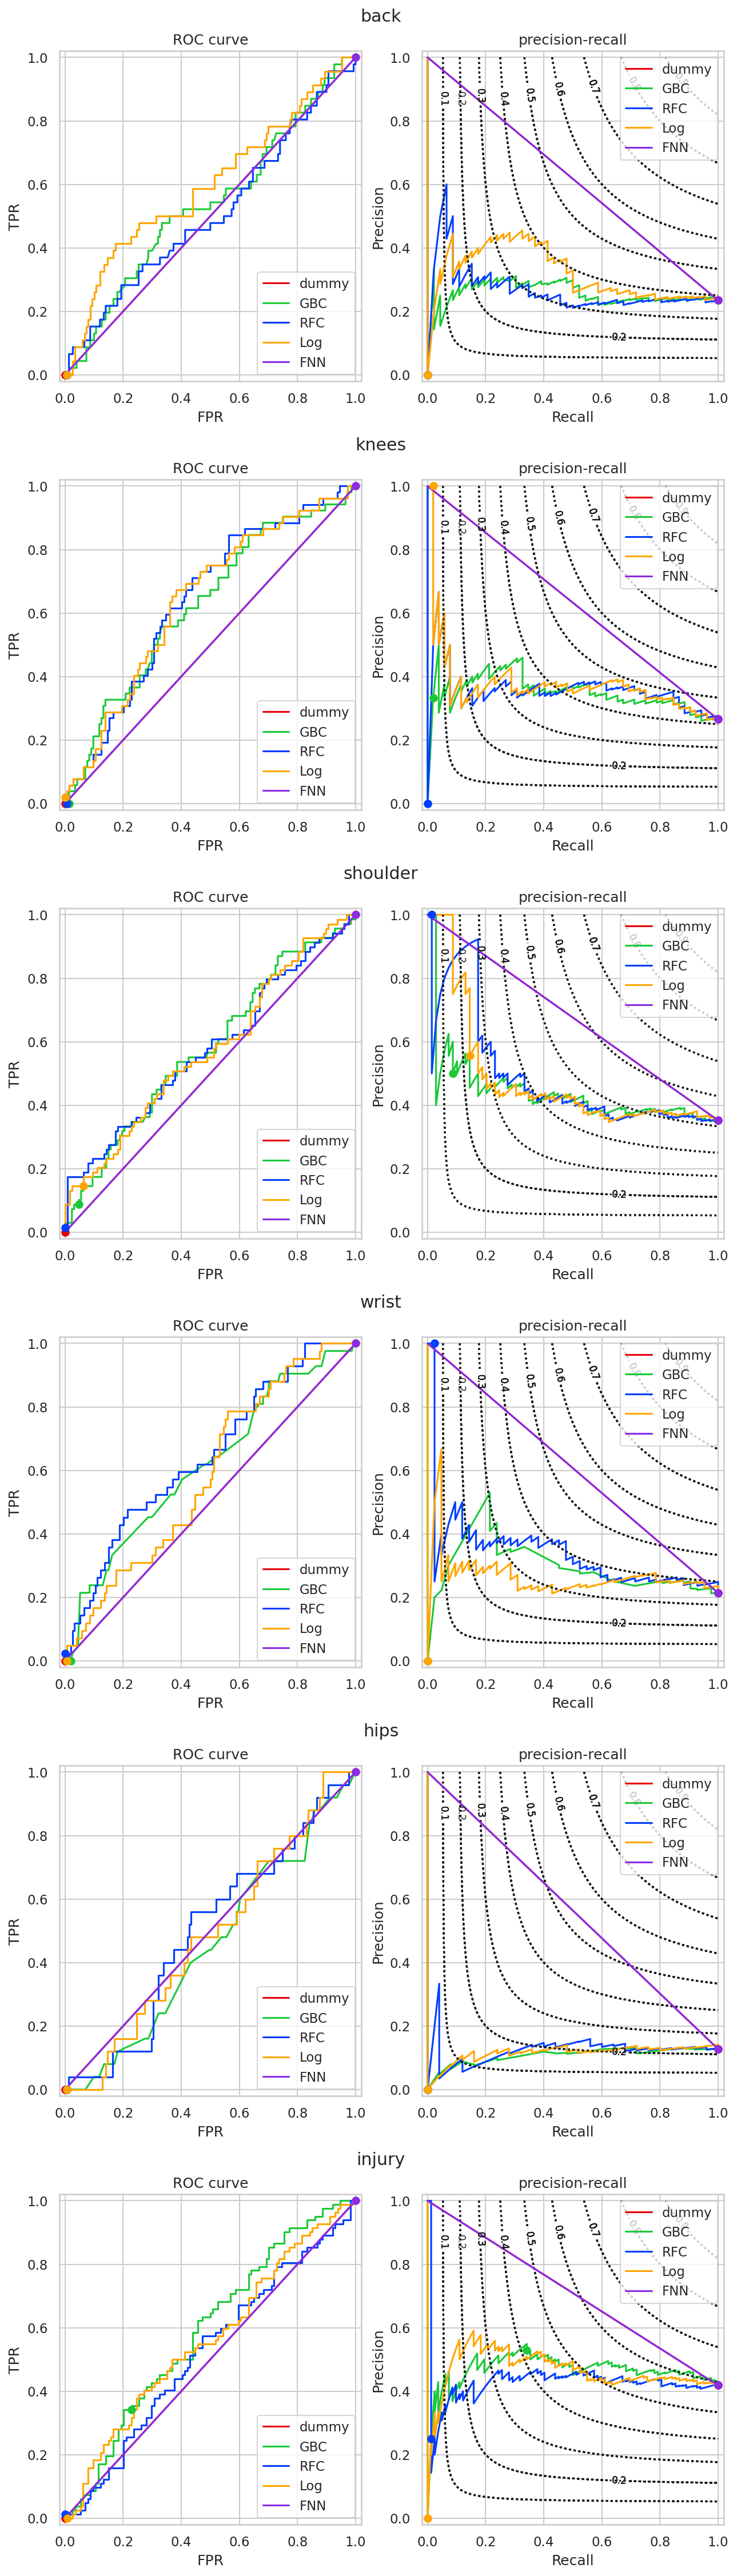

In [14]:
Image('ROC unequal train.png')

**Inspecting these ROC curves shows one thing – these models do not reasonably work as classifiers no matter what decision threshold we would pick.**

# Conclusion

We have not discovered America here, the fact that choosing the right metric when dealing with imbalanced data is paramount is well known. But there are several things that are astounding here:
* The accuracies of these classifiers for injuries of different bodyparts are very obviously corresponding to the majority category. It is very interesting that none of the authors noticed this.
* The authors extracted feature importances and interpreted them as the strong predictors of injury occurence. Mathematicall speaking, the models were "trained", and feature importances do exist and can be extracted. The issue here is that the overall model does not really predict anything, so the feature importance is irrelevant.
* First author is a **Director**  of **Center for Statistical Training and Consulting** at **Michigan State University**. Shouldn't such a person know better, and spot these errors from afar?
* This article passed a peer review in a Q1 journal.

What to take from this? **Do not trust something just because it is signed by a real professional, published in a good journal, and contains the magic words *'machine learning'*.**

## Can we do better?

Let us address the data imbalance issue by random undersampling of the majority category. We are going to do that by hand, even though we could use e.g. sklearn's RandomUnderSampler. The held-out test set has the same category ratio as the original dataset.

**Result:** This does not lead to interesting results. The resulting classifiers assign labels basically at random (achieving accuracies around 50 %). Implementing oversampling of the minority category might be an alternative approach (e.g. SMOTE), but there is also a possibility that the collected data simply does not contain information that would allow for reasonable injury classification.




 back 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
DummyClassifier(strategy='most_frequent')
Fitting 10 folds for each of 24 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features='sqrt',
                           n_estimators=10,
                           random_state=RandomState(MT19937) at 0x7C5DB2E1FE40)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=2, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5DB2E1FC40)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=1, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DB2E1F740)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
)



 knees 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
DummyClassifier(strategy='most_fr

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 10 folds for each of 24 candidates, totalling 240 fits
GradientBoostingClassifier(learning_rate=0.2, max_depth=1, max_features='sqrt',
                           n_estimators=50,
                           random_state=RandomState(MT19937) at 0x7C5DB2E1FB40)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=3,
                       random_state=RandomState(MT19937) at 0x7C5DB2E1F540)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.1, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DB2E1FA40)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
)



 shoulder 

Fitting 10 folds for each of 1 candidates, 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='sqrt',
                           n_estimators=50,
                           random_state=RandomState(MT19937) at 0x7C5DB2E1F840)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=2, n_estimators=50,
                       random_state=RandomState(MT19937) at 0x7C5DB2E1F640)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.1, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5E0722EA40)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
)



 wrist 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
DummyClassifier(strategy='most

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 10 folds for each of 24 candidates, totalling 240 fits
GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='sqrt',
                           n_estimators=20,
                           random_state=RandomState(MT19937) at 0x7C5E0722EB40)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=2, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5E0722EC40)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.1, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5E0722E640)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
)



 hips 

Fitting 10 folds for each of 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features='sqrt',
                           n_estimators=10,
                           random_state=RandomState(MT19937) at 0x7C5DA02B4840)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=3, n_estimators=30,
                       random_state=RandomState(MT19937) at 0x7C5DA02B4A40)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.01, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DA02B4240)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
)



 injury 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
DummyClassifier(strategy='mo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='sqrt',
                           n_estimators=20,
                           random_state=RandomState(MT19937) at 0x7C5DA02B4040)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
RandomForestClassifier(max_depth=2,
                       random_state=RandomState(MT19937) at 0x7C5DA02B4940)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression(C=0.01, max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7C5DA02B5440)
Fitting 10 folds for each of 6 candidates, totalling 60 fits
<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MyModel(
    (layer1): Linear(in_features=38, out_features=500, bias=True)
    (layer2): Linear(in_features=500, out_features=1, bias=True)
    (drop): Dropout(p=0.4, inplace=False)
  ),
)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


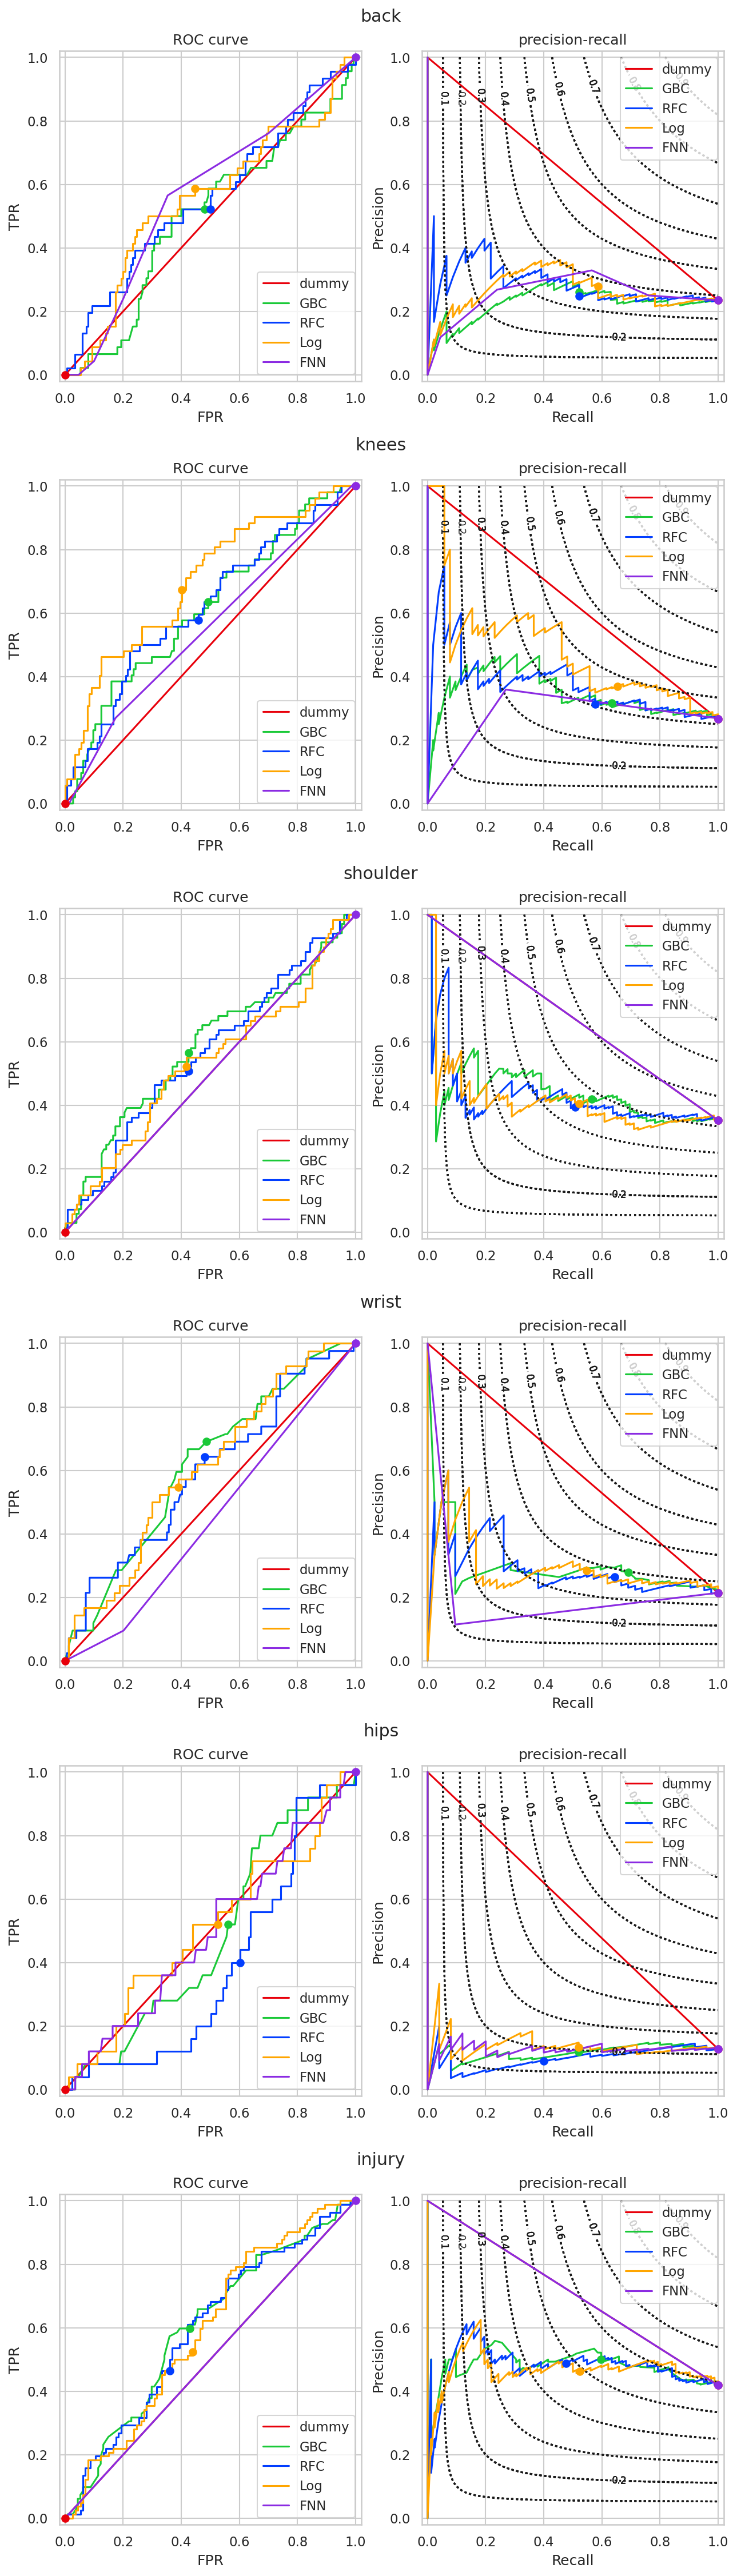

dummy    GBC    RFC    Log    FNN
Injury location Score                                       
back            accuracy   0.765  0.541  0.515  0.546  0.235
                recall     0.000  0.522  0.522  0.587  1.000
                precision  0.000  0.261  0.247  0.278  0.235
                f1         0.000  0.348  0.336  0.378  0.380
                AUC        0.500  0.499  0.557  0.552  0.571
knees           accuracy   0.735  0.541  0.556  0.612  0.276
                recall     0.000  0.635  0.577  0.654  1.000
                precision  0.000  0.317  0.316  0.370  0.268
                f1         0.000  0.423  0.408  0.472  0.423
                AUC        0.500  0.613  0.620  0.700  0.551
shoulder        accuracy   0.648  0.566  0.551  0.566  0.648
                recall     0.000  0.551  0.507  0.522  0.000
                precision  0.000  0.413  0.393  0.409  0.000
                f1         0.000  0.472  0.443  0.459  0.000
                AUC        0.500  0.580  0.565  0.534  0.500
wrist           accuracy   0.786  0.566  0.546  0.607  0.648
                recall     0.000  0.667  0.643  0.548  0.095
                precision  0.000  0.283  0.267  0.284  0.114
                f1         0.000  0.397  0.378  0.374  0.104
                AUC        0.500  0.613  0.591  0.608  0.447
hips            accuracy   0.872  0.449  0.413  0.510  0.128
                recall     0.000  0.520  0.400  0.520  1.000
                precision  0.000  0.119  0.091  0.134  0.128
                f1         0.000  0.194  0.148  0.213  0.226
                AUC        0.500  0.482  0.385  0.510  0.494
injury          accuracy   0.582  0.587  0.566  0.546  0.582
                recall     0.000  0.598  0.463  0.524  0.000
                precision  0.000  0.505  0.481  0.462  0.000
                f1         0.000  0.547  0.472  0.491  0.000
                AUC        0.500  0.599  0.594  0.593  0.500

In [15]:
# setting different plot theme
sns.set_theme(style='whitegrid', palette='bright')
# setting a random state to replicate randomised results
rnd = np.random.RandomState(10)

# creating resulting scores table to store all scores
cls_nm = ['dummy', 'GBC', 'RFC', 'Log', 'FNN']  # abbrev of classifiers
scores = ['accuracy', 'recall', 'precision', 'f1', 'AUC']
index = pd.MultiIndex.from_product([inj_loc, scores],
                                   names=['Injury location', 'Score'])
scores = pd.DataFrame(index=index,
                      dtype=float)
del index  # cleaning up

# set up for plots
# =============================================================================
fig = plt.figure(figsize=(10, 30), dpi=150)
subfigs = fig.subfigures(6, 1)
colors = ['r', 'g', 'b', 'orange', 'm']  # to ensure color consistency in plots
# set up to plot f1 score contours
array_0_1 = np.linspace(0.01, 1, 100)
f1_grid = np.empty((100, 100))
for i, a in enumerate(array_0_1):
    for ii, b in enumerate(array_0_1):
        f1_grid[i, ii] = 2*a*b/(a+b)
grid = np.meshgrid(array_0_1, array_0_1)
del array_0_1, i, a, ii, b

# run setups
# =============================================================================
# storage for all the best models
trained_best = {}

# folds for Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rnd)

# define pipeline for GridSearch over different estimators
pipeline = pp.Pipeline([('scaler', MinMaxScaler()),
              #          ('engineer', PolynomialFeatures(degree=2)),
               #         ('selector', SelectPercentile(chi2, percentile=10)),
                        ('estim', LogisticRegression())])

# specify the neural network  as a sklearn estimator using Skorch library
# -----------------------------------------------------------------------
stopper = EarlyStopping()
net = NeuralNetBinaryClassifier(module=MyModel(hid_feat=1, out_feat=1),
                                optimizer=optim.Adam,
                                max_epochs=30,
                                device='cuda',
                                callbacks=[stopper],
                                verbose=0)
# parameter/estimator grid to search over
params = [
          # Dummy Classifier – assigns everything with 0
          {'estim': [DummyClassifier(strategy='most_frequent')]},
          # GBC
          {'estim': [GradientBoostingClassifier(max_features='sqrt',
                                                random_state=rnd)],
           'estim__learning_rate': [0.01, 0.1, 0.2, 0.5],
           'estim__n_estimators': [10, 20, 50],
           'estim__max_depth': [1, 2]
           },
          # Random Forest
          {'estim': [RandomForestClassifier(max_features='sqrt',
                                            random_state=rnd)],
           'estim__n_estimators': [30, 50, 100],
           'estim__max_depth': [2, 3]
           },
          # Logistic regression
          {'estim': [LogisticRegression(max_iter=1000,
                                        random_state=rnd)],
           'estim__C': [0.01, 0.1, 1, 10, 100]
           },
          # FNN
          {'estim': [net],
           'estim__module__hid_feat': range(500, 3001, 500),
           'estim__module__out_feat': [1]
           }
          ]

# set up work data frame
df = data.copy().astype(np.float32)

# loops through different locations of injuries
# =============================================================================
for i, loc in enumerate(inj_loc):
    print('\n\n\n',
          '================================================================\n',
          loc, '\n',
          '================================================================'
          '\n')
    # split original data into train-test to preserve distribution of classes
    # in test set
    df_train, df_test = train_test_split(df, train_size=0.8,
                                         stratify=data[loc],
                                         random_state=rnd)
    # test set can be split right away:
    X_test = df_test.drop(inj_loc, axis='columns').copy()
    y_test = df_test[loc].copy()

    # split the train data into positive and negative labels
    df_train_pos = df_train[df_train[loc] == 1]
    # take only the negative cases and create sample with the same size as the
    # positive dataset
    df_train_neg = df_train[df_train[loc] == 0].sample(n=df_train_pos.shape[0],
                                                       random_state=rnd)
    # join the positive and negative datasets and shuffle them
    df_train = pd.concat([df_train_pos, df_train_neg],
                         axis='index').sample(frac=1.0, random_state=rnd)
    # we can now separate target and predictors
    X_train = df_train.drop(inj_loc, axis='columns').copy()
    y_train = df_train[loc].copy()

    # create key to store best estimated models
    trained_best[loc] = []
    # initialise plot for given injury location
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(loc)

    # loops through different estimators in parameter/estimator grid
    # =========================================================================
    # NOTE: if I was looking for the best classifier, I would ommit this
    # loop and pass the whole params as a param_grid into GridSearchCV
    for ii, param_grid in enumerate(params):
        # set up grid-search cross validation, score for recall
        model = GridSearchCV(pipeline,
                             param_grid,
                             cv=skf,
                             scoring='recall',
                             n_jobs=-1,
                             refit=True,
                             verbose=1)

        # fit the model
        model.fit(X_train, y_train)

        # select, display and store the best model
        best_model = model.best_estimator_  # select
        print(best_model.named_steps['estim'])  # display
        trained_best[loc].append(best_model)  # store

        # model prediction for TEST sets
        # =====================================================================
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # model  scoring for TEST set
        # =====================================================================
        # accuracy
        acc = accuracy_score(y_test, y_pred)
        scores.loc[(loc, 'accuracy'), cls_nm[ii]] = acc
        # recall
        recall = recall_score(y_test, y_pred)
        scores.loc[(loc, 'recall'), cls_nm[ii]] = recall
        # precision
        precision = precision_score(y_test, y_pred)
        scores.loc[(loc, 'precision'), cls_nm[ii]] = precision
        # f1 score
        f1 = f1_score(y_test, y_pred)
        scores.loc[(loc, 'f1'), cls_nm[ii]] = f1
        # compute AUC
        auc = roc_auc_score(y_test, y_prob)
        scores.loc[(loc, 'AUC'), cls_nm[ii]] = auc

        # plotting ROC curves
        # =====================================================================
        # calculating FPR and TPR for each threshold level
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        # plot ROC curve
        axs[0].plot(fpr, tpr,
                    label=f'{cls_nm[ii]}',
                    color=colors[ii])
        # find index of the threshold closest to 0.5
        thr_idx = np.argmin(np.abs(thresh - 0.5))
        # plot the defauls decision point onto ROC curve
        axs[0].plot(fpr[thr_idx], tpr[thr_idx],
                    color=colors[ii], marker='o',
                    zorder=10)
        # subplots visual adjustments
        axs[0].set_title('ROC curve')
        axs[0].set_xlabel('FPR')
        axs[0].set_ylabel('TPR')
        axs[0].legend(loc='lower right')

        # plotting precision-recall curves
        # =====================================================================
        # plotting f1 contours
        f1_score_plot = axs[1].contour(grid[0], grid[1], f1_grid,
                                       levels=np.arange(0, 1, 0.1),
                                       linestyles='dotted', colors='k')
        axs[1].clabel(f1_score_plot, inline=True, fontsize=8)

        # calculating precision and recall for each threshold level
        prec, rec, thresh = precision_recall_curve(y_test, y_prob)
        # plot ROC curve
        axs[1].plot(rec, prec,
                    label=f'{cls_nm[ii]}',
                    color=colors[ii])
        # find index of the threshold closest to 0.5
        thr_idx = np.argmin(np.abs(thresh - 0.5))
        # plot the defauls decision point onto ROC curve
        axs[1].plot(rec[thr_idx], prec[thr_idx],
                    color=colors[ii], marker='o',
                    zorder=10)
        # subplots visual adjustments
        axs[1].set_title('precision-recall')
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].legend(loc='upper right')

    for ax in axs.flat:
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)

# save plot
plt.savefig('ROC unequal train.png', bbox_inches='tight')
plt.show()

# cleaining up
del acc, auc, ax, axs, best_model, loc, params

scores.round(3)